# Rating Prediction Project - Amazon Reviews

Fine-tune BERT to predict star ratings (1-5) based on combined review text and summary.

**GOAL: PREDICT THE RATING(1-5 STARS) FROM REVIEW TEXT**

In [203]:
# Install necessary packages
#!pip install transformers datasets scikit-learn pandas torch tqdm matplotlib

**1. Data Preparation**
Gather your review_text and rating pairs.  
Split into train / validation / test sets.  

**2. Text Preprocessing**
Options:  
Basic: lowercasing, punctuation removal, stopwords removal, lemmatization  
Or use pre-trained models that handle this internally (e.g. transformers).  


**3: Text Representation (Vectorization)**  
Several options:  
**a) TF-Ireviews_df + regression model:**  
    Use Tfireviews_dfVectorizer to convert text → feature vectors.  
    Feed into regression model (e.g. LinearRegression, Ridge, SVR, RandomForestRegressor).  
**b) Word embeddings + regression model**  
    Use Word2Vec, GloVe, or sentence embeddings (e.g. Sentence-BERT) to convert text → vector.  
    Feed into regressor.  
**c) End-to-end transformer model (best results)**    
    Fine-tune BERT, DistilBERT, or RoBERTa to directly predict the rating from text.  
    Implement with HuggingFace Transformers.  

**4: Model Training**  
    Loss: Mean Squared Error (MSE) or Mean Absolute Error (MAE).  
    Evaluation: R², RMSE, MAE, etc.  

In [63]:
# Imports
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
#from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [65]:
file_path = "/Users/roshan_thakur/Desktop/MachineLearning/ML-Project/Datasets/Amazon-Reviews/amazon_review.csv"
reviews_df = pd.read_csv(file_path,encoding="latin")
reviews_df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [67]:
#Change column name from overall to rating for clarity
reviews_df = reviews_df.rename(columns={'overall': 'rating'})

reviews_df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,rating,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [69]:
# Combine reviewText and summary
reviews_df['summary'] = reviews_df['summary'].fillna('')
reviews_df['combined_text_summary'] = reviews_df['summary'] + ' ' + reviews_df['reviewText']

# Use combined_text and overall
reviews_df = reviews_df[['combined_text_summary', 'rating']].dropna()
reviews_df['rating'] = reviews_df['rating'].astype(int)

In [75]:
reviews_df.head(5)

,combined_text_summary,rating
0,Four Stars No issues.,4
1,"MOAR SPACE!!! Purchased this for my device, it...",5
2,nothing to really say.... it works as expected...,4
3,Great buy at this price!!! *** UPDATE This th...,5
4,best deal around Bought it with Retail Packagi...,5


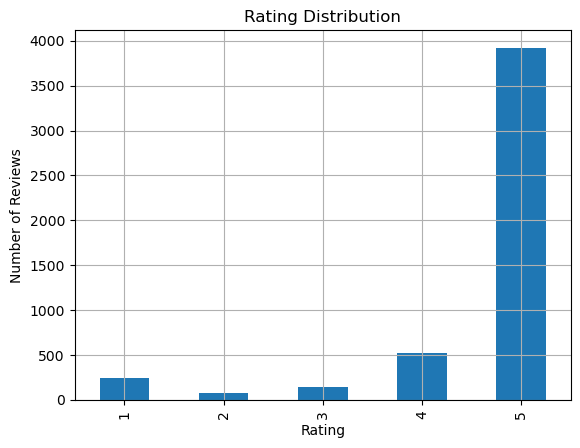

In [77]:
# Plot rating distribution
# sort_index() ensures ratings appear in order (1, 2, 3, 4, 5)
reviews_df['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Rating Distribution')
plt.grid(True)
plt.show()

The plot diagram reveals the counts of how many reviews exist for each rating. A balanced review dataset will have evenly distributed ratings, while a skewed plot indicates imbalance. Polarization, common in product reviews, shows many 5-star and 1-star ratings but few middle ratings.

**To confirm if we have data imbalance, let's calculate the exact imbalance % in the dataset.**

In [79]:
# Count total reviews
total_reviews = len(reviews_df)

# Count reviews per rating
rating_counts = reviews_df['rating'].value_counts().sort_index()

# Calculate % per rating
rating_percentages = (rating_counts / total_reviews) * 100

# Display
print("Rating distribution (percentage):")
for rating, pct in rating_percentages.items():
    print(f"Rating {rating}: {pct:.2f}% ({rating_counts[rating]} reviews)")


Rating distribution (percentage):
Rating 1: 4.97% (244 reviews)
Rating 2: 1.63% (80 reviews)
Rating 3: 2.89% (142 reviews)
Rating 4: 10.72% (527 reviews)
Rating 5: 79.79% (3921 reviews)


As we can see from the plot diagram and the imbalance %, that ~80% of reviews are 5 stars. Hence we can conclude that the 
data is **highly imbalanced.** And if we decide to use the data **as-is** to train the model, the model will be strongly biased
to predict 5 stars as it has so many examples.

**For LLMs and NLP models, it is very helpful to see how long the reviews are and if it needs to be truncated.**

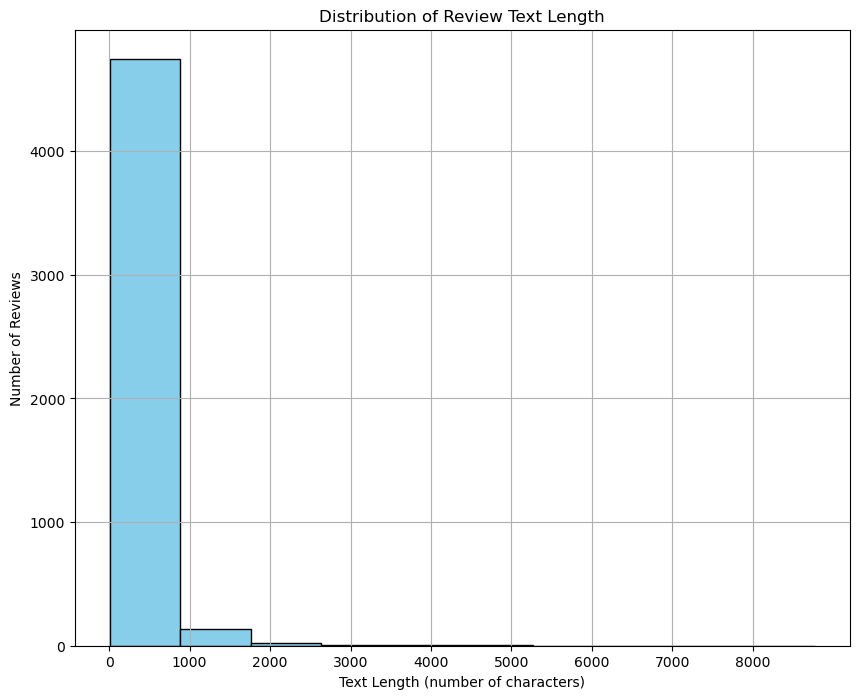

In [91]:
# Compute text length (in characters)
reviews_df['text_length'] = reviews_df['combined_text_summary'].apply(len)

# Plot histogram of text lengths
plt.figure(figsize=(10,8))
plt.hist(reviews_df['text_length'], bins = 10, color='skyblue', edgecolor='black')
plt.xlabel('Text Length (number of characters)')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Review Text Length')


# Add custom tick marks
import numpy as np
plt.xticks(np.arange(0, reviews_df['text_length'].max() + 1, 1000))
plt.yticks(np.arange(0, plt.ylim()[1] + 1, 1000))

plt.grid(True)
plt.show()


The plot above shows that:

80-90% of reviews are under 500 characters which is very short.  
There is a long tail of long reviews which are rare but present.  
The distribution is highly skewed.  

**BALANCE THE DATASET**

Original rating counts:
1     244
2      80
3     142
4     527
5    3921
Name: rating, dtype: int64

Target samples per class (smallest class): 80

Balanced rating counts:
1    80
2    80
3    80
4    80
5    80
Name: rating, dtype: int64


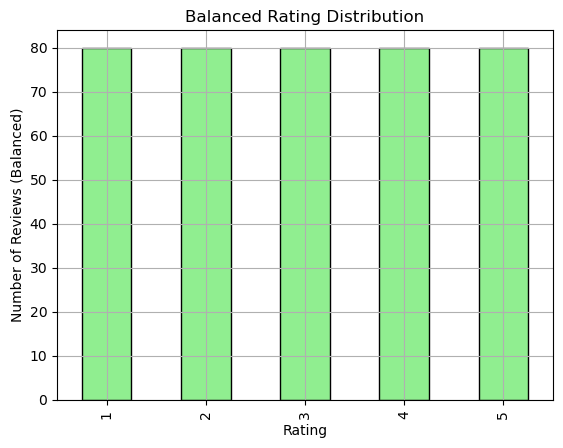

In [97]:
# Step 1: Compute current counts
rating_counts = reviews_df['rating'].value_counts().sort_index()
print("Original rating counts:")
print(rating_counts)

# Step 2: Determine minimum class size
min_count = rating_counts.min()
print(f"\nTarget samples per class (smallest class): {min_count}")

# Step 3: Undersample each class to min_count
#Create a balanced dataset by ensuring each rating category has the same number of samples
balanced_df = reviews_df.groupby('rating').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

# Step 4: Check balanced counts
balanced_counts = balanced_df['rating'].value_counts().sort_index()
print("\nBalanced rating counts:")
print(balanced_counts)

# Step 5: Plot balanced distribution
balanced_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews (Balanced)')
plt.title('Balanced Rating Distribution')
plt.grid(True)
plt.show()

**MODELING PIPELINE**

In [99]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Split the balanced data
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df['combined_text_summary'],
    balanced_df['rating'],
    test_size=0.2,
    random_state=42
)

**Option A — TF-IDF + Ridge Regression (Baseline)**

In [112]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features = 500)  # You can adjust max_features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(vectorizer.get_feature_names_out())

['000' '10' '1080p' '12' '16' '16gb' '20' '2013' '30' '30mb' '32' '32gb'
 '34' '4kb' '59' '64' '64gb' '8gb' 'able' 'about' 'actually' 'adapter'
 'add' 'advertised' 'after' 'again' 'ago' 'all' 'almost' 'already' 'also'
 'always' 'am' 'amazon' 'amount' 'an' 'and' 'android' 'another' 'any'
 'anything' 'app' 'are' 'around' 'as' 'at' 'average' 'away' 'back' 'bad'
 'be' 'because' 'been' 'before' 'being' 'best' 'better' 'between' 'big'
 'bit' 'black' 'both' 'bought' 'box' 'brand' 'built' 'but' 'buy' 'buying'
 'by' 'came' 'camera' 'cameras' 'can' 'cannot' 'capacity' 'card' 'cards'
 'cell' 'cheap' 'check' 'chip' 'class' 'compatible' 'complaints'
 'completely' 'computer' 'connected' 'copy' 'corrupted' 'cost' 'could'
 'couldn' 'couple' 'customer' 'da' 'damaged' 'data' 'day' 'days' 'dead'
 'deal' 'december' 'decent' 'decided' 'defective' 'definitely' 'delete'
 'desktop' 'device' 'devices' 'did' 'didn' 'died' 'difference' 'different'
 'disappointed' 'disk' 'do' 'does' 'doesn' 'doing' 'don' 'done' '

In [114]:
# Train Ridge regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred = ridge_model.predict(X_test_tfidf)

# Evaluate model
print("TF-IDF + Ridge Regression Results")
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))

TF-IDF + Ridge Regression Results
R²: 0.4088259402797362
RMSE: 1.1709629946175442
MAE: 0.9909945363207762


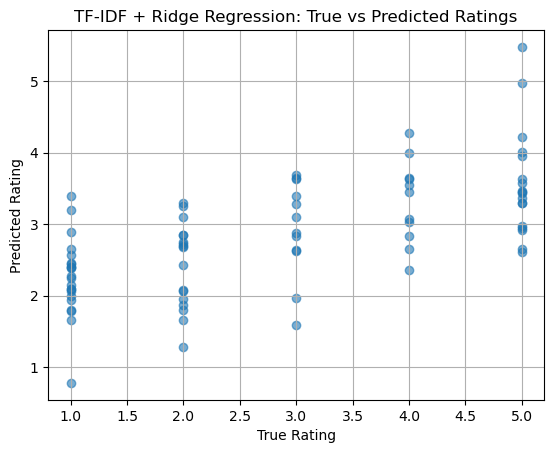

In [116]:
# Plot true vs predicted ratings
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")
plt.title("TF-IDF + Ridge Regression: True vs Predicted Ratings")
plt.grid(True)
plt.show()

We see a lot of spread vertically for each true rating:

Many predictions cluster around ~2 to ~4 for every true rating.The model is not confidently predicting the extreme ratings (1 or 5).

For true rating = 1, many predictions are around 2-3 instead of 1.
For true rating = 5, many predictions are around 3-4, not exactly 5.

**Overall pattern**
The model seems to have a regression to the mean behavior:

Tends to predict around 2.5 to 4 regardless of input.Less confident in predicting very low or very high ratings.

This is common in imbalanced datasets and when using Ridge regression (which penalizes large weights).

**TF-IDF WITH PROPER TEXT PREPROCESSING**

In [148]:
# Install NLTK if needed
#!pip install nltk

# Import libraries
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources (first time only)
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join back to string
    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/roshan_thakur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/roshan_thakur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [150]:
# Apply preprocessing to train and test text
X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)

In [164]:
# Vectorize preprocessed text
vectorizer = TfidfVectorizer(max_features=500)
X_train_tfidf = vectorizer.fit_transform(X_train_processed)
X_test_tfidf = vectorizer.transform(X_test_processed)

# Train Ridge regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred_preprocessed = ridge_model.predict(X_test_tfidf)

# Evaluate model
print("TF-IDF + Ridge (with preprocessing) Results")
print("R²:", r2_score(y_test, y_pred_preprocessed))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_preprocessed)))
print("MAE:", mean_absolute_error(y_test, y_pred_preprocessed))

TF-IDF + Ridge (with preprocessing) Results
R²: 0.3853981698194764
RMSE: 1.193939747171084
MAE: 1.0116514929909584


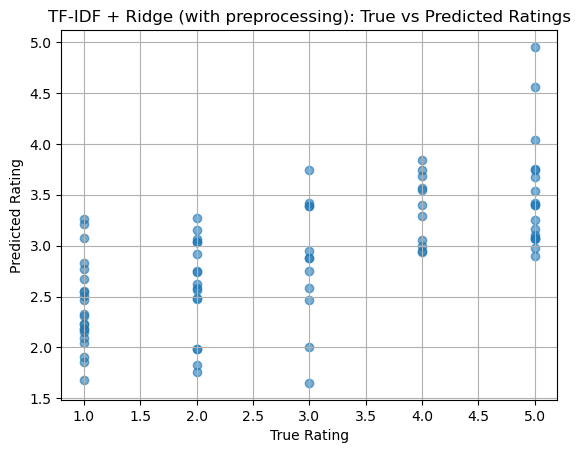

In [154]:
# Plot true vs predicted ratings
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")
plt.title("TF-IDF + Ridge (with preprocessing): True vs Predicted Ratings")
plt.grid(True)
plt.show()


**Sentence-BERT + RandomForestRegressor (Better semantics)**

In [136]:
#import sys
#!{sys.executable} -m pip install sentence-transformers

In [134]:
# Install SentenceTransformers if not already installed
#!pip install sentence-transformers

# Import necessary libraries
from sentence_transformers import SentenceTransformer 
from sklearn.ensemble import RandomForestRegressor

# Load Sentence-BERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight, fast model

# Encode training and test sentences
X_train_embeddings = sbert_model.encode(X_train.tolist(), show_progress_bar=True)
X_test_embeddings = sbert_model.encode(X_test.tolist(), show_progress_bar=True)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_embeddings, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_embeddings)

# Evaluate model
print("Sentence-BERT + RandomForestRegressor Results")
print("R²:", r2_score(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Sentence-BERT + RandomForestRegressor Results
R²: 0.39754082457558615
RMSE: 1.1820866085021013
MAE: 0.9916249999999998


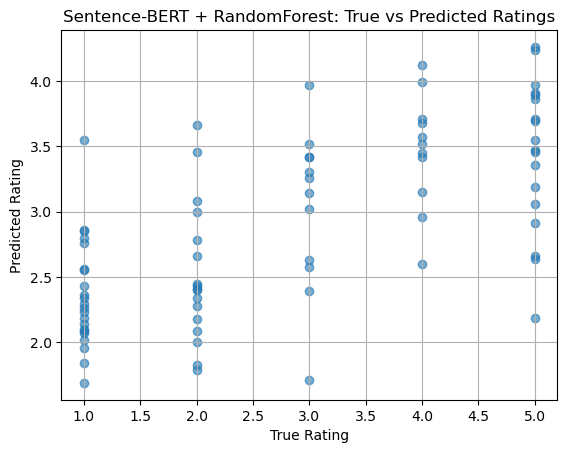

In [140]:
# Plot true vs predicted ratings
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")
plt.title("Sentence-BERT + RandomForest: True vs Predicted Ratings")
plt.grid(True)
plt.show()

Observations:

For higher true ratings (4, 5), the predicted ratings tend to be higher.
For lower true ratings (1, 2), the predictions are lower.
For true rating 1:
Predicted ratings mostly between ~1.7 to ~3.5.
The model struggles to predict exactly 1.
For true rating 5:
Predicted ratings mostly between ~2.9 to ~4.3.
The model under-predicts the highest ratings.
The model shows regression to the mean behavior:
Many predictions cluster around ~2.5 to ~3.5, even for extreme true ratings.

In [209]:
# Calculate metrics
# Sentence-BERT + RandomForestRegressor
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# TF-IDF + Ridge Regression
r2_ridge = r2_score(y_test, y_pred)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
mae_ridge = mean_absolute_error(y_test, y_pred)


# TF-IDF + Ridge (with preprocessing) Results
r2_ridge_preprocessing = r2_score(y_test, y_pred)
rmse_ridge_preprocessing = np.sqrt(mean_squared_error(y_test, y_pred))
mae_ridge_preprocessing = mean_absolute_error(y_test, y_pred)

# Create DataFrame
results_df = pd.DataFrame({
    'Model': ['Sentence-BERT + RandomForestRegressor', 'TF-IDF + Ridge Regression', 'TF-IDF + Ridge Regression(preprocessing)'],
    'R2': [r2_rf, r2_ridge, r2_ridge_preprocessing],
    'RMSE': [rmse_rf, rmse_ridge, rmse_ridge_preprocessing],
    'MAE': [mae_rf, mae_ridge, mae_ridge_preprocessing]
})

# Display DataFrame
print(results_df)

                                      Model        R2      RMSE       MAE
0     Sentence-BERT + RandomForestRegressor  0.397541  1.182087  0.991625
1                 TF-IDF + Ridge Regression  0.385398  1.193940  1.011651
2  TF-IDF + Ridge Regression(preprocessing)  0.385398  1.193940  1.011651


In [205]:
#!pip install transformers datasets


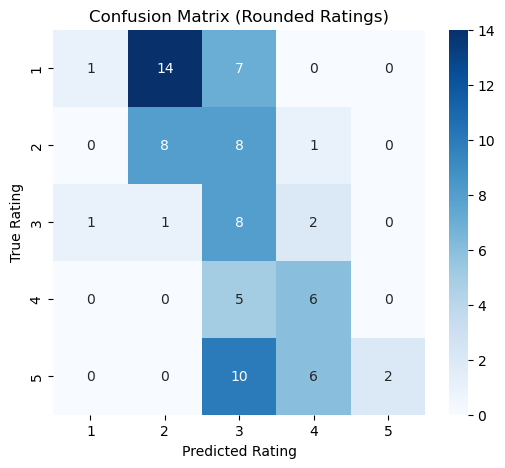

In [211]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Round predictions to nearest integer between 1 and 5
y_pred_rounded = np.clip(np.round(y_pred), 1, 5)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rounded, labels=[1, 2, 3, 4, 5])

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4,5],
            yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted Rating")
plt.ylabel("True Rating")
plt.title("Confusion Matrix (Rounded Ratings)")
plt.show()

**Ratings 1 and 2:**
True rating 1 → 14 predicted as 2, 7 as 3 → model struggles to predict 1-star correctly. Only 1 correctly predicted as 1.

The model tends to underestimate how bad the review is.

True rating 2 → 8 predicted as 2 → this is decent.

But 8 predicted as 3 → confused between 2 and 3.

👉 Conclusion → Model struggles to predict very low ratings (1, 2). Tends to shift them toward the middle (3).

**Ratings 3:**
True rating 3 → 8 predicted correctly.

2 predicted as 4 → some tendency to slightly overpredict.

👉 Conclusion → Model is reasonably accurate at predicting 3-star reviews.

**Ratings 4:**
True rating 4 → 6 correctly predicted as 4.

5 predicted as 3 → tendency to underpredict 4-star reviews a bit.

**Ratings 5:**
True rating 5 → only 2 predicted correctly.

10 predicted as 3, 6 as 4 → model strongly underpredicts 5-star reviews.

👉 Conclusion → Model struggles with 5-star reviews — tends to push them toward 3 or 4.